In [1]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.seasonal import STL
# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

# Generate simulated 10 day dataset from Zinser et al experimental data
1. Combine Hourly Qc data, PAR, gross 14C fixation, carbon loss into one dataset. 
>a) Calculate net carbon fixation from gross fixation and carbon loss
2. Repeat days from original dataset 5x to get 10 day simulated dataset.
3. Randomly remove data of certain percentages.
4. Run iterative interpolation to impute new values. 
5. Compare imputed values against original values to calculate error (RMSE).
6. Block bootstrap to get uncertainites for productivity measurements.

### Calculating hourly Qc from FCM and combining with measurements data
Returns single dataframe with all necessary data for analysis: `pro_data`

In [2]:
# read in flow cytometry data
culture_data=pd.read_csv('simulation_data/zinser_figure2a.csv')
psd_data=pd.read_csv('simulation_data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('simulation_data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get c-fixation and loss data
gt = xr.open_dataset('simulation_data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
# add net c-fiszation for all rows
pro_data['NPP'] = pro_data['GPP']-pro_data['carbonloss']

### Generate 10 day simulated dataset
Cuts off the last day to repeat to produce continuous transition into next simulated days

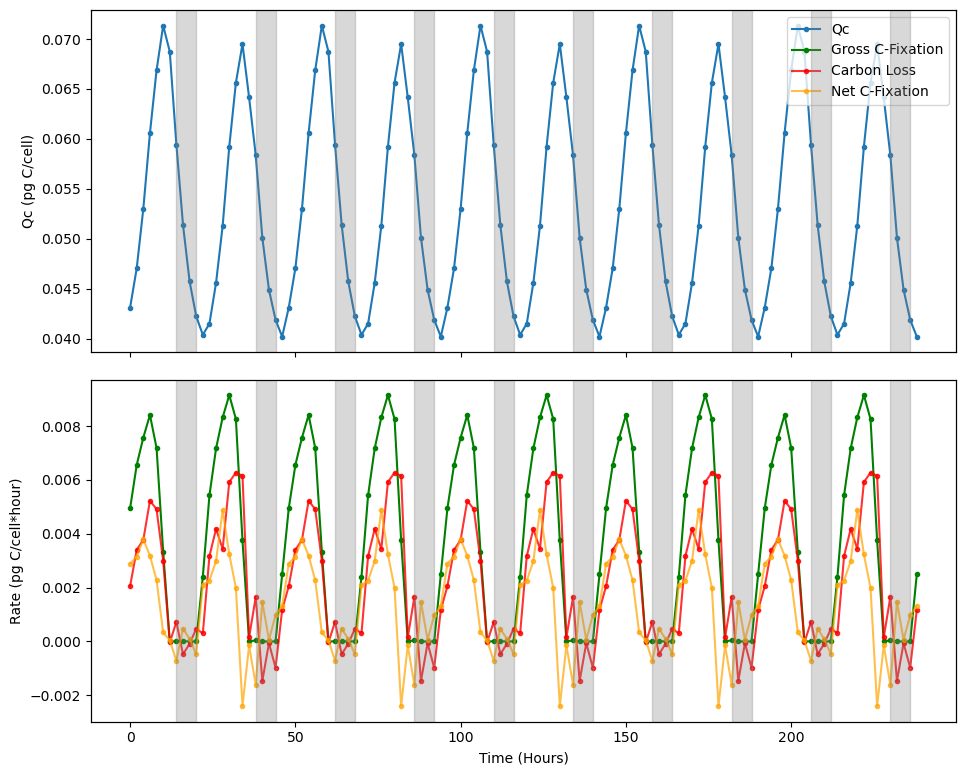

In [3]:
# create 10 day simulated data for Qc data
ten_days=generate_simulated(pro_data, 10)

#### Plot to check if simulation successful ####
plot_simulated_rates(ten_days)

### Randomly remove data 
Try with varying percentages of missing data

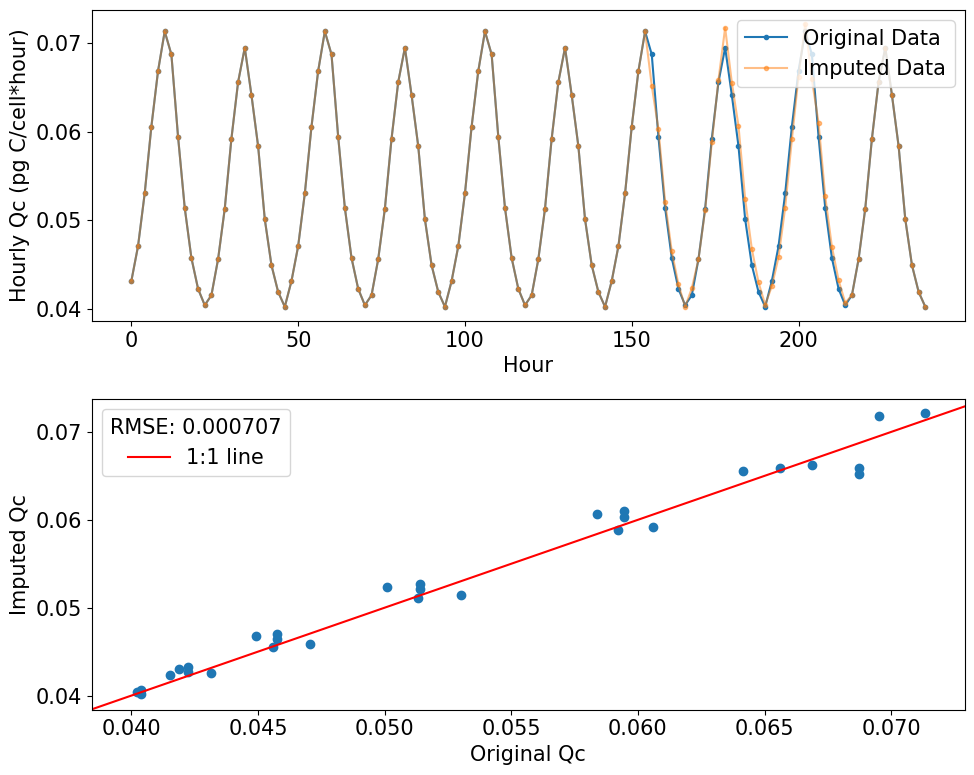

In [4]:
from sklearn.metrics import mean_squared_error
# generate missing data
# missing_25=generate_missing_data(ten_days, 0.25)
missing_25=generate_missing_chunks(ten_days, 30, 0.25)
# calculate imputed values
impute_df=run_imputation(missing_25)

#### plot results ####
plot_imputed(impute_df)

### Calculate Imputation Error Metrics
Percent Bias (PB), Coverage Rate (CR), and Average Width (AW) ([Reference](https://stefvanbuuren.name/fimd/sec-evaluation.html))
- Percent Bias is calculated by taking the average of (actual - predicted) / abs(actual) across all observations. ([reference](https://rdrr.io/cran/Metrics/man/percent_bias.html#:~:text=Percent%20Bias%20is%20calculated%20by,(actual)%20across%20all%20observations.)
- Coverage rate/probability is calculated by the number of true values that fall within the CI (here I use 95% but not sure if too wide/narrow). We can simulate many runs to get an average lower/upper q, then check each true value against the CI range. 

In [5]:
# # store data here
# dfs=[]
# # calculate qs
# low_q=[]
# up_q=[]
# # simulate runs
# for n in range(0,100):
#     missing_25=generate_missing_chunks(ten_days, 30, 0.25)
#     # calculate imputed values
#     impute_df=run_imputation(missing_25)
#     # store vals
#     dfs.append(impute_df)
#     low_q.append(lower_q(impute_df['with_missing']))
#     up_q.append(upper_q(impute_df['with_missing']))
    
# ## helper function to calculate percent bias
# def calc_pb(df):
#     obs=df['Qc_hour']
#     pred=df['with_missing']
#     return np.mean((obs-pred)/np.abs(obs)) * 100


# sim_dfs=pd.concat(dfs)
# calc_pb(sim_dfs)
# # calculate mean CI
# mean_low, mean_up = np.mean(low_q), np.mean(up_q)
# # how many observed values fall within CI

### Calculate growth rates and productivity on imputed datasets
Compare against measurements to get error

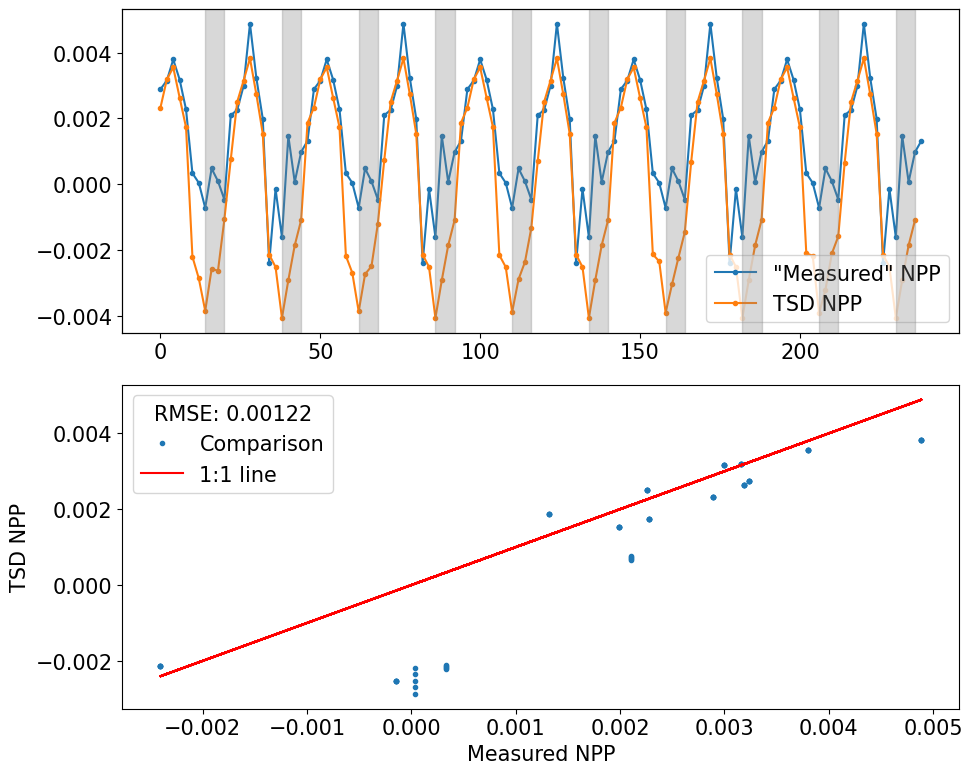

In [6]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')

# get tsd components
tsd_df=run_STL(impute_df, 'with_missing')
# calculate hourly growth by exponential growth and maintain correct order
tsd_df['hourly_growth']=exp_growth(tsd_df, 'diel',2).shift(-1)
# calculate hourly productivity
rates_df=calc_productivity(tsd_df,'hourly_growth','Qc_hour')

#### Plot results ####
fig,rmse=plot_productivity(tsd_df)

### Create baseline
Calculate growth rate and productivity without decomposition

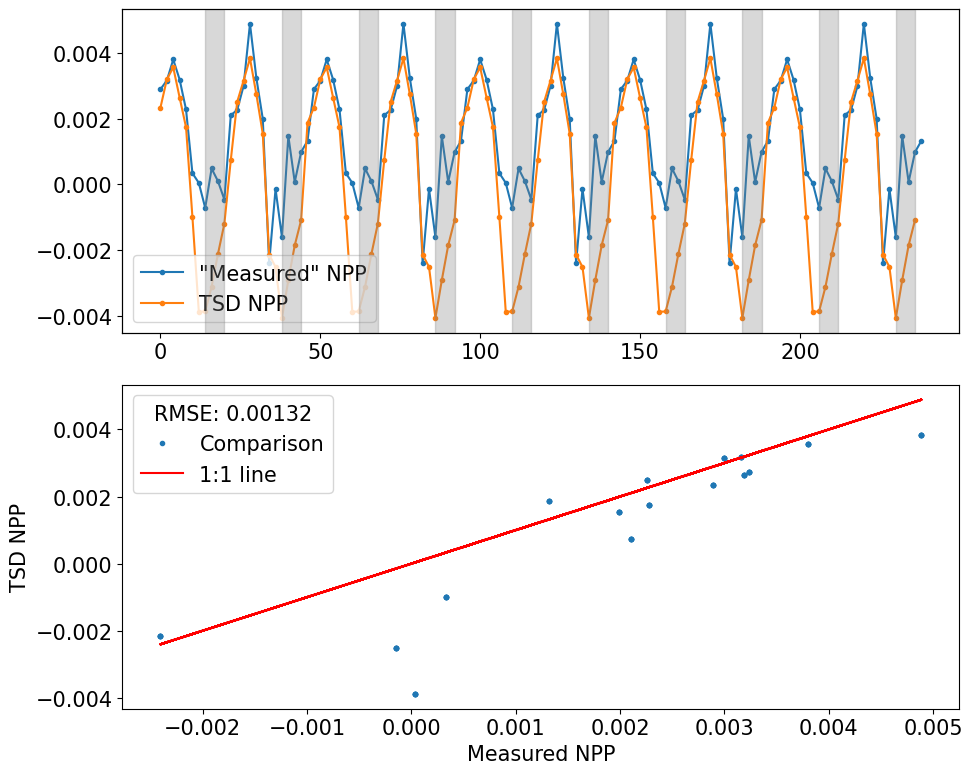

In [7]:
## generate simulated data
base_growth=exp_growth(ten_days,'Qc_hour',2).shift(-1)
# add to data
baseline=ten_days.copy()
baseline['hourly_growth']=base_growth
baseline=calc_productivity(baseline, 'hourly_growth','Qc_hour')
# plot
fig,rmse=plot_productivity(baseline)

### Run moving block bootstrapping (MBB) on models to get uncertainty values

1. Get residual values
2. Separate residuals into _l_ length blocks
3. Randomly draw with resampling to create new time series of residuals
4. Combine with seasonal and trend components to generate new synthetic time series
5. Calculate new productivity values from synthetic time series
6. Repeat **_n_** times to get distribution of error

#### References
- Medium [guide](https://medium.com/@daydreamersjp/bootstrapping-on-time-series-data-moving-block-bootstrap-79aaf6648aec)
- Bergmeier et al. [slides](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cbergmeir.com/talks/bergmeir2014ISF_slides.pdf)
- Medium [tutorial (with paywall)](https://archive.ph/LSshc)


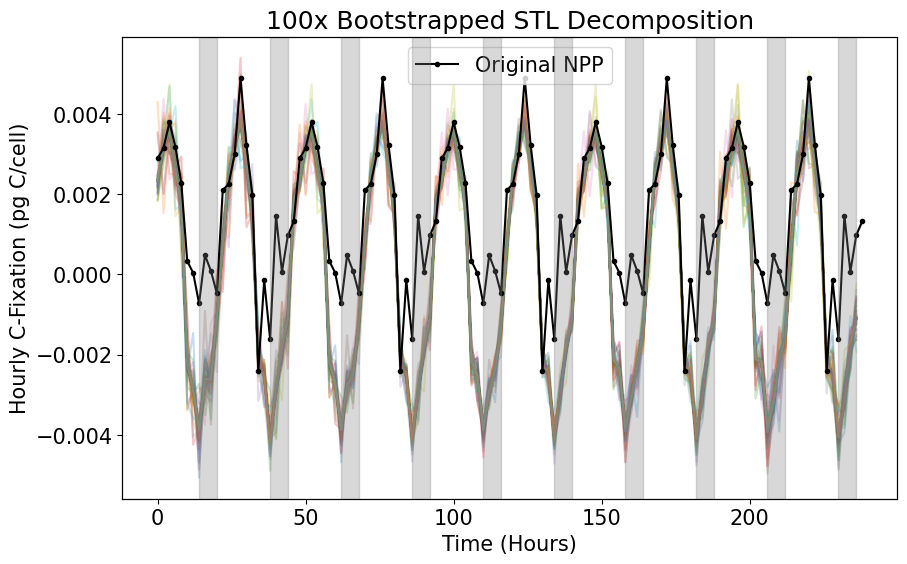

In [8]:
# run bootstrapping to get list of new dataframes
runs=100
mbb_df, mbb_data=run_bootstrapping(tsd_df, model='STL',runs=runs)
plot_bootstrapping(mbb_df, mbb_data, runs)

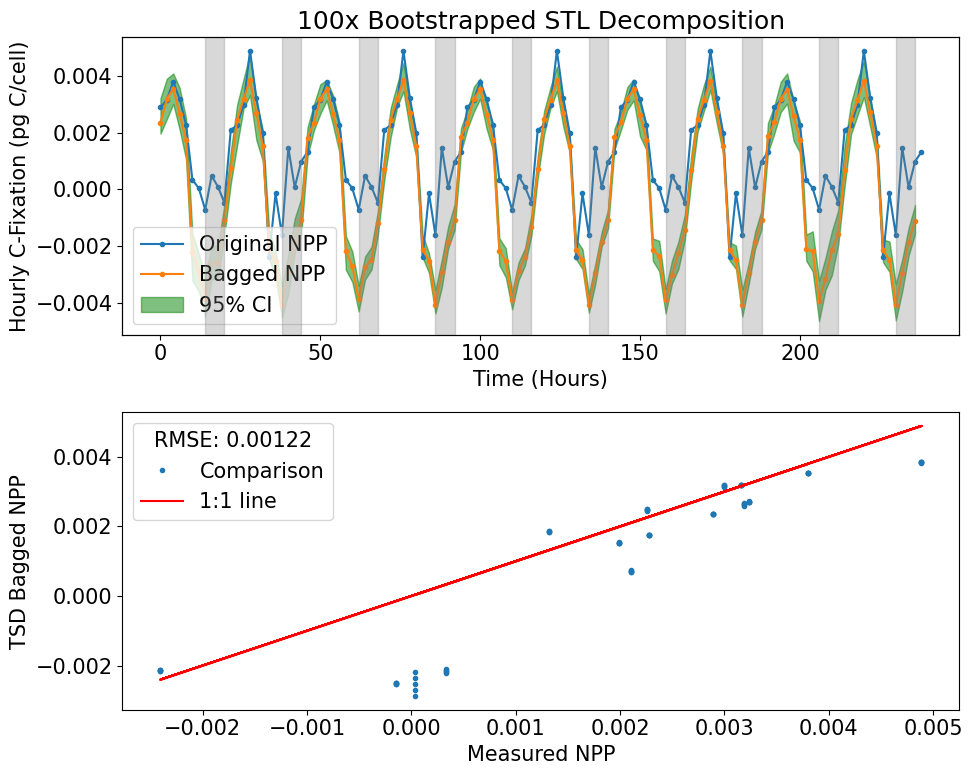

In [9]:
# perform bagging on bootstrapped data
bagged=bagging_results(mbb_data)

## plot results
fig,rmse=plot_bagging(bagged, model='STL')

### Put it all together and test for amount of data removed
Uncomment cell below to rerun, but this takes about ~15 minutes to complete. Alternatively, run the preloaded pickle file to check previous results 

- This cell runs bagged model 100x to collect aggregated error (RMSE, sMAPE, and mase)  in this case. 

In [11]:
def summarize_rolling(seasonal, trend, resid):
    # join all components
    all_comp=pd.concat([seasonal, trend, resid], axis=1)
    # drop duplicates
    all_comp = all_comp.loc[:,~all_comp.columns.duplicated()]
    # group by on each hour for mean
    comp_mean = all_comp.groupby(['hour']).mean().reset_index()
    return(comp_mean)

1.2061711046689187

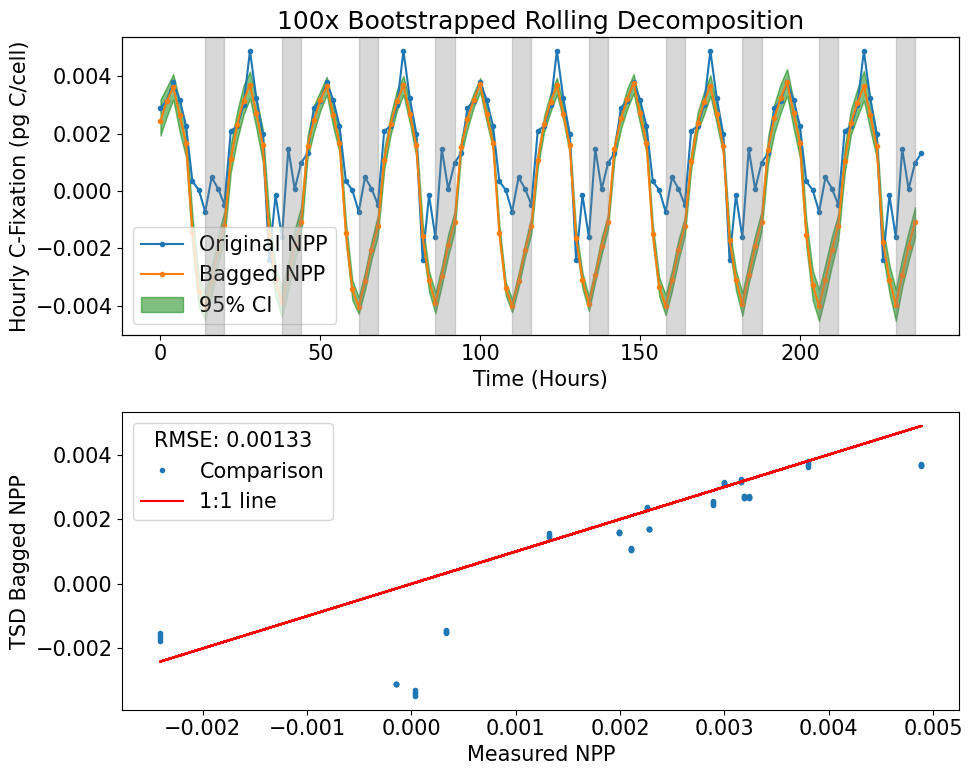

In [15]:

pro_seasonal, pro_trend, pro_resid = rolling_tsd(ten_days.set_index('hour'), 'Qc_hour', period=12,
                                                 window=3, type='multiplicative', extrapolate=True)
pro_all=summarize_rolling(pro_seasonal, pro_trend, pro_resid)
pro_all.rename(columns={'seasonal':'diel'}, inplace=True)
# get other necessary columns`a
pro_all=pd.merge(pro_all, ten_days[['hour','Qc_hour','par','NPP']], on='hour')
# calculate growth and productivity
pro_all['hourly_growth']=exp_growth(pro_all, 'diel',2).shift(-1)
pro_all=calc_productivity(pro_all, 'hourly_growth', 'Qc_hour')
# bootstrap model
rolling_mbb_df, rolling_mbb_data=run_bootstrapping(pro_all)
# perform bagging on bootstrapped data
roll_bagged=bagging_results(rolling_mbb_data)
## plot results
fig,rmse=plot_bagging(roll_bagged,'Rolling')
# get error metrics
days_only = roll_bagged.loc[roll_bagged['par_mean']>0]
# calculate error metrics
pred=days_only.productivity_mean[:-1]
actual=days_only.NPP_mean[:-1]
rmse, smape, mase=error_metrics(pred, actual)

In [12]:
def summarize_rolling(seasonal, trend, resid):
    # join all components
    all_comp=pd.concat([seasonal, trend, resid], axis=1)
    # drop duplicates
    all_comp = all_comp.loc[:,~all_comp.columns.duplicated()]
    # group by on each hour for mean
    comp_mean = all_comp.groupby(['hour']).mean().reset_index()
    return(comp_mean)

In [20]:
## helper function to run model simulations
# input: pro_data=dataframe of original zinser dataset, data_len=integer specifying number of days to replicate,
# model = string representing model type (must be 'STL', 'baseline', or 'rolling'),
# model_runs = int for simulations to run, save_data=boolean to save data in files 
def run_model_simulations(pro_data, data_len, model, show_plots=True, model_runs=100, save_data=True):
    # list of data percentages to remove
    to_remove=[0, 0.1, 0.25, 0.4, 0.5, 0.6]
    # save error metrics distribution
    rmse_dist=[]
    smape_dist=[]
    mase_dist=[]
    # run model 100 times to collect error distributions
    for i in range(0,100):
        # save rmses in each proportion
        print(i)
        rmses=[]
        smapes=[]
        mases=[]
        # run model for several iterations
        for prop in to_remove:
            # run model
            rmse, smape, mase=run_full_model(pro_data, data_len, prop, 
                                             model=model, runs=model_runs, show_plots=show_plots)
            print(f'data removed: {prop}, RMSE: {rmse}, MASE: {mase}')
            # save errors
            rmses.append(rmse)
            smapes.append(smape)
            mases.append(mase)
        # save list of rmses
        rmse_dist.append(rmses)
        smape_dist.append(smapes)
        mase_dist.append(mases)
    if save_data:
        ## Save files
        print('saving dfs...')
        to_df(rmse_dist, to_remove, 'RMSE').to_pickle(f'simulation_data/{model}_rmse_df')
        to_df(mase_dist, to_remove, 'MASE').to_pickle(f'simulation_data/{model}_mase_df')
    # return error distributions as dataframes
    return(to_df(rmse_dist), to_df(mase_dist))

In [21]:
#### For baseline model
base_rmse_df, base_mase_df=run_model_simulations(pro_data, 100, 'baseline', 
                                                     model_runs=100, save_data=True)

## for STL model
stl_rmse_df, stl_mase_df=run_model_simulations(pro_data, 100, 'STL', 
                                                     model_runs=100, save_data=True)

0
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0013940293171003355, MASE: 1.2842362387498825
data removed: 0.25, RMSE: 0.001466966042364584, MASE: 1.373755078441132
data removed: 0.4, RMSE: 0.0015133988101346384, MASE: 1.4620930021845338
data removed: 0.5, RMSE: 0.0015169519559785803, MASE: 1.4695466852904875
data removed: 0.6, RMSE: 0.001447663548290188, MASE: 1.409918355245423
1
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.001376507211698019, MASE: 1.2716906373525814
data removed: 0.25, RMSE: 0.0014702844628363095, MASE: 1.3801126231193843
data removed: 0.4, RMSE: 0.0015117740663328364, MASE: 1.4304367996091967
data removed: 0.5, RMSE: 0.0015146281103544275, MASE: 1.4808929118082474
data removed: 0.6, RMSE: 0.0015329353247260761, MASE: 1.4831045629613182
2
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0013789077564233033, MASE: 

data removed: 0.6, RMSE: 0.001663856328072035, MASE: 1.596124076796032
19
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.001376476700409484, MASE: 1.2656717014347745
data removed: 0.25, RMSE: 0.0014784470507140958, MASE: 1.3977157603284025
data removed: 0.4, RMSE: 0.0015369266823864172, MASE: 1.4676201537827926
data removed: 0.5, RMSE: 0.0015456718446216445, MASE: 1.497623096267658
data removed: 0.6, RMSE: 0.0015418737239039524, MASE: 1.4927122651907723
20
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.001376905317139705, MASE: 1.2907053122765084
data removed: 0.25, RMSE: 0.0014647808203382758, MASE: 1.4032019611598696
data removed: 0.4, RMSE: 0.001514662618365968, MASE: 1.4575745254893104
data removed: 0.5, RMSE: 0.0015374583268885113, MASE: 1.4700376727496909
data removed: 0.6, RMSE: 0.0014870591064093843, MASE: 1.4606970036067934
21
data removed: 0, RMSE: 0.0013159803023224952, MASE

data removed: 0.5, RMSE: 0.0014841060738904103, MASE: 1.421311373752294
data removed: 0.6, RMSE: 0.00150909303313324, MASE: 1.5010491730001838
38
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0013860943993013884, MASE: 1.2656502874633737
data removed: 0.25, RMSE: 0.001516344539982742, MASE: 1.4184640515551141
data removed: 0.4, RMSE: 0.0015277059374707075, MASE: 1.482660064001819
data removed: 0.5, RMSE: 0.0014975737717932423, MASE: 1.4680125033363232
data removed: 0.6, RMSE: 0.0014960223485502653, MASE: 1.4259584163457188
39
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0014025392902961684, MASE: 1.2928677658537748
data removed: 0.25, RMSE: 0.0014194465225501156, MASE: 1.3298990913209172
data removed: 0.4, RMSE: 0.0014848641082566994, MASE: 1.4242308930319103
data removed: 0.5, RMSE: 0.001543892937509008, MASE: 1.4721954191419286
data removed: 0.6, RMSE: 0.0015127490422639372, MASE:

data removed: 0.4, RMSE: 0.0015560404651088007, MASE: 1.5141575602781545
data removed: 0.5, RMSE: 0.001528797152753273, MASE: 1.5009846789237573
data removed: 0.6, RMSE: 0.0015097531764793888, MASE: 1.4752249247531146
57
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0013804848751734788, MASE: 1.289097976821348
data removed: 0.25, RMSE: 0.0014708907995013463, MASE: 1.3952649236981713
data removed: 0.4, RMSE: 0.0015568634481477814, MASE: 1.4893818372893384
data removed: 0.5, RMSE: 0.0015040781374877554, MASE: 1.4749114901192695
data removed: 0.6, RMSE: 0.00146766621755035, MASE: 1.4161412699130416
58
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.001384966144379271, MASE: 1.28579751552649
data removed: 0.25, RMSE: 0.0014948115963733192, MASE: 1.429582229477396
data removed: 0.4, RMSE: 0.0014230788502539583, MASE: 1.3893726111685691
data removed: 0.5, RMSE: 0.0015754698214292709, MASE: 1

data removed: 0.25, RMSE: 0.0014797440583057169, MASE: 1.401523637606276
data removed: 0.4, RMSE: 0.0015462240571663076, MASE: 1.4794278792725
data removed: 0.5, RMSE: 0.0015457713234259946, MASE: 1.4958685138004706
data removed: 0.6, RMSE: 0.0014876576542517698, MASE: 1.4583493215429426
76
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0013720812714028056, MASE: 1.2691697608672878
data removed: 0.25, RMSE: 0.0014453318309949944, MASE: 1.3733328560519535
data removed: 0.4, RMSE: 0.001487083452649842, MASE: 1.421398921914819
data removed: 0.5, RMSE: 0.0014797722312515753, MASE: 1.4328995948710082
data removed: 0.6, RMSE: 0.0015513932168781828, MASE: 1.500597396710278
77
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0013459555551678035, MASE: 1.2335908938587028
data removed: 0.25, RMSE: 0.001448904244131333, MASE: 1.3606018534049178
data removed: 0.4, RMSE: 0.0014722536471552111, MASE: 

data removed: 0.1, RMSE: 0.0014040061910493807, MASE: 1.2981314551392262
data removed: 0.25, RMSE: 0.0014035067147996165, MASE: 1.3251023115055467
data removed: 0.4, RMSE: 0.0015021514606982065, MASE: 1.4384873886547815
data removed: 0.5, RMSE: 0.001539412456476376, MASE: 1.4816549833987753
data removed: 0.6, RMSE: 0.0015076713075125212, MASE: 1.4819546759518292
95
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0013567085364841888, MASE: 1.255525700167431
data removed: 0.25, RMSE: 0.0014693492301525665, MASE: 1.384559921756427
data removed: 0.4, RMSE: 0.0015202914535988122, MASE: 1.4459377224937744
data removed: 0.5, RMSE: 0.001492561143998664, MASE: 1.4297054300217467
data removed: 0.6, RMSE: 0.0014564437226203882, MASE: 1.4242889926442355
96
data removed: 0, RMSE: 0.0013159803023224952, MASE: 1.1961317307979284
data removed: 0.1, RMSE: 0.0014163126071440888, MASE: 1.328067965444938
data removed: 0.25, RMSE: 0.0014000703621108084, MAS

TypeError: to_df() missing 2 required positional arguments: 'cols' and 'error'

## Interpreting Error Metrics
- RMSE
    - Good for comparing relative errors across models (want to minimize this)
- sMAPE (symetric mean absolute percent error)
    - good [reference](https://medium.com/@davide.sarra/how-to-interpret-smape-just-like-mape-bf799ba03bdc)
    - still not sure whether to scale from 0-100 or 0-200
    - BAD for values close to 0, should probably normalize values first
- WMAPE (weighted mean absolute percent error(
    - mitigates large errors for values close to 0
    - [reference](https://medium.com/@vinitkothari.24/time-series-evaluation-metrics-mape-vs-wmape-vs-smape-which-one-to-use-why-and-when-part1-32d3852b4779)
- MASE (mean absolute scaled error)
    - needs to be scaled to another model (seasonal naive, data point at season back)
    - [explanation](https://help.anaplan.com/advanced-metrics--15d0d0c4-b374-497b-aae9-e42138a13c2f#mase)
    - [more details](https://medium.com/@ashishdce/mean-absolute-scaled-error-mase-in-forecasting-8f3aecc21968)
    
    

Do I care about absolute error (ie how far off the prediction is from the actual result?) Or is relative error more importatn?
- perhaps RMSE and MASE is good, and sMAPE is not required (could consider WMAPE)

In [12]:
def to_df(dist,cols, error):
    df=pd.DataFrame(dist)
    df.columns=cols
    return(df.melt(var_name='removed', value_name=error))

import seaborn as sns
def error_boxplot(df, error, model):
    fig,axs=plt.subplots(figsize=(10,6))
    sns.boxplot(data=df, x='removed',y=error, palette=sns.color_palette("viridis"))
    axs.set_xlabel('Proportion of Data removed (%)')
    axs.set_ylabel(error)
    axs.set_title(f'%Data Removed vs. Error: {model}')
    plt.show()

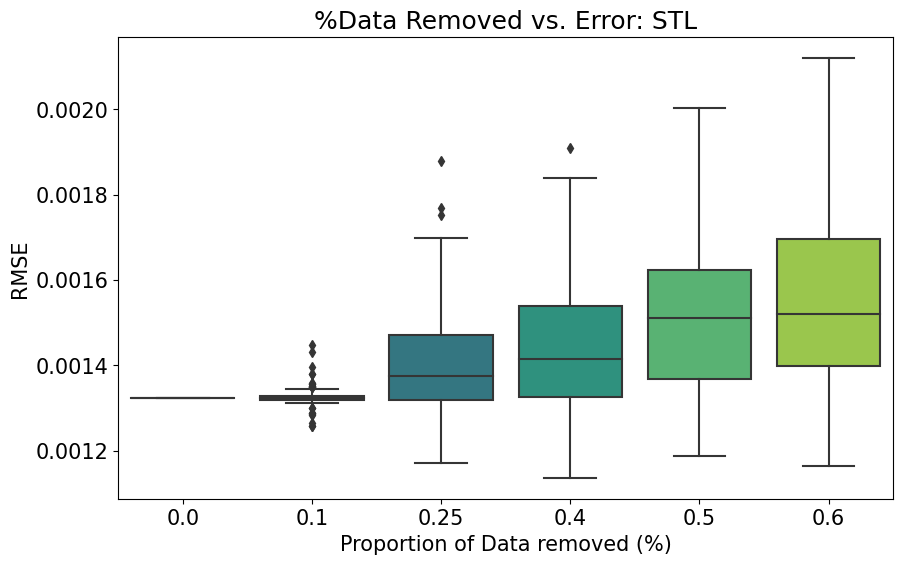

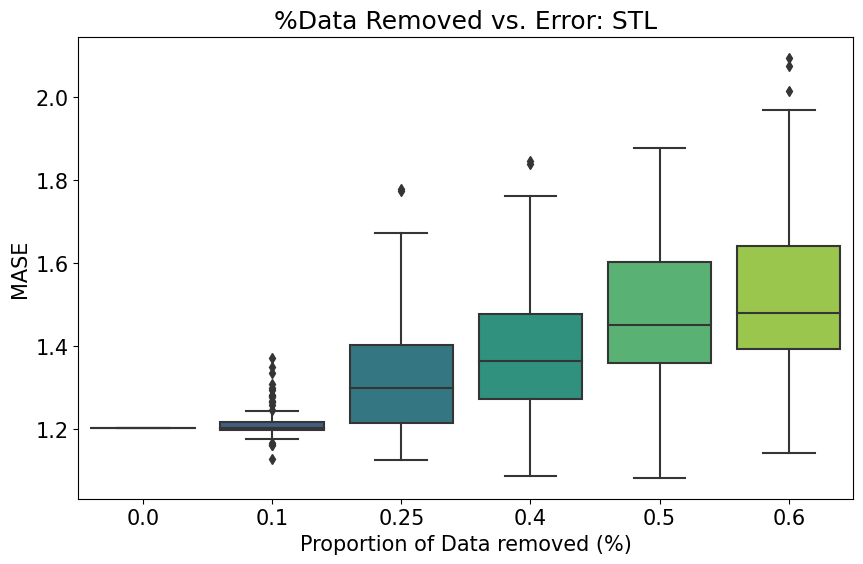

In [16]:
rmse_df=to_df(rmse_dist, to_remove, 'RMSE')
error_boxplot(rmse_df, 'RMSE', 'STL')

mase_df=to_df(mase_dist, to_remove, 'MASE')
error_boxplot(mase_df, 'MASE', 'STL')

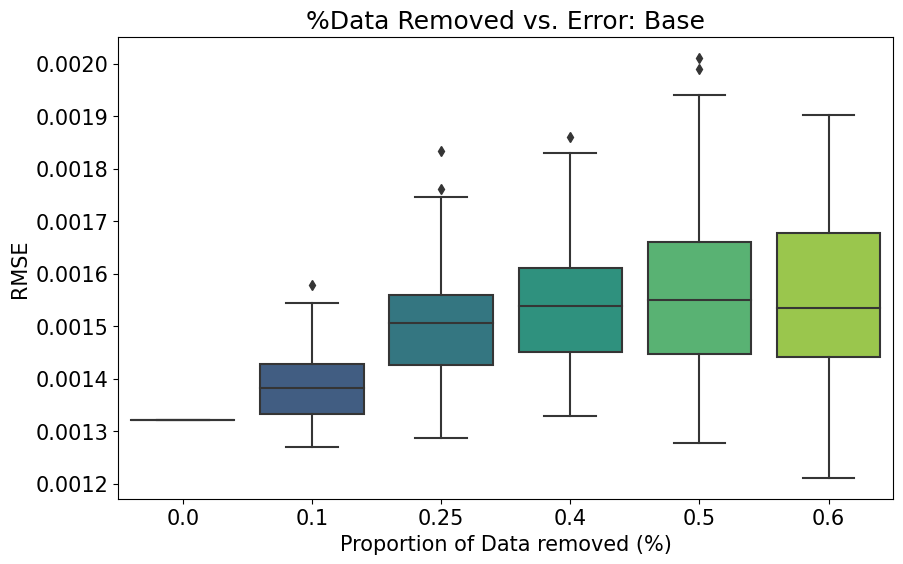

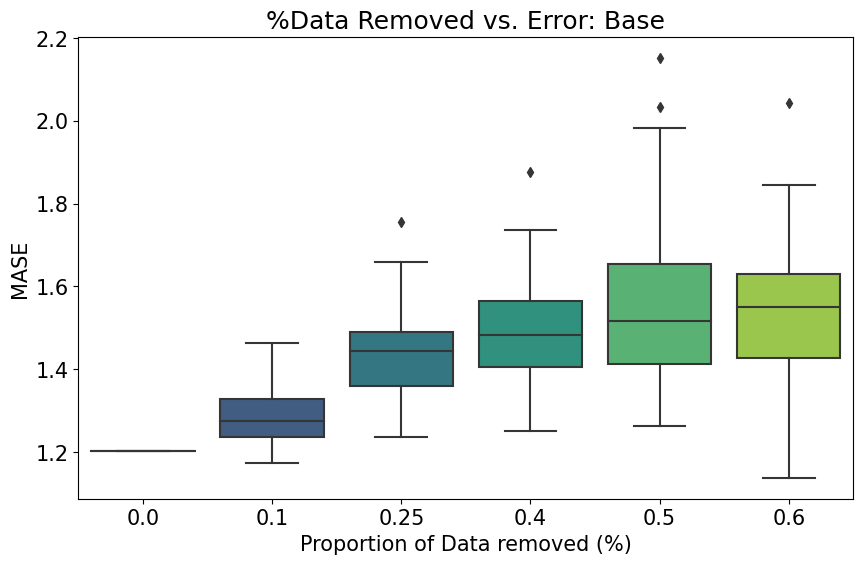

In [22]:
# plot error 
error_boxplot(base_rmse_df, 'RMSE', 'Base')
error_boxplot(base_mase_df, 'MASE', 'Base')

### Post-hoc procedure for ranking models
- What type of error do I want to minimize and why?

For example, I could use the Hochberg post-hoc method to reduce the number of false positives. This would mean that I would prioritize against incorrectly rejecting the true null hypothesis. I could use the true results (NPP values) as a control and the different models to compare against. The baseline would be Annette's method to calculate NPP. 

In [ ]:
rmse_long=rmse_df.melt(var_name='removed', value_name='rmse')

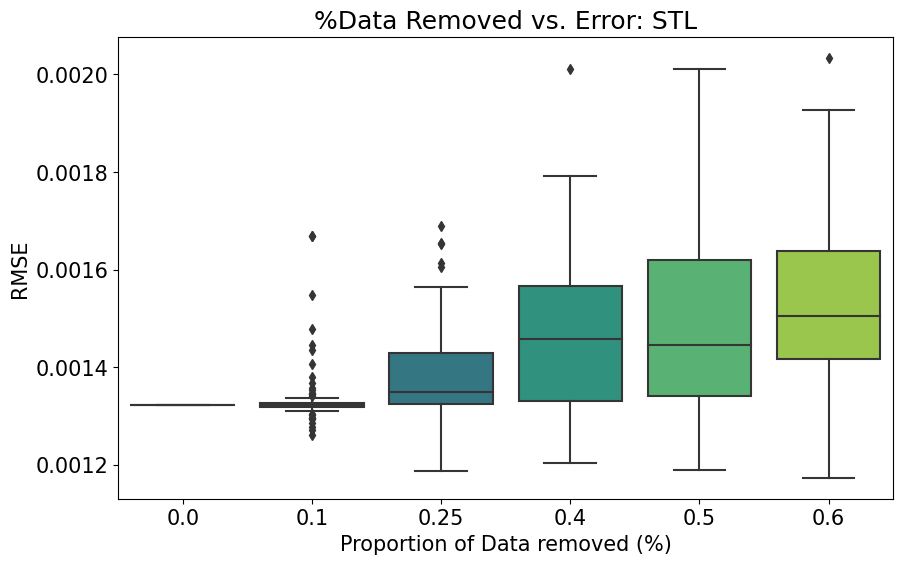

In [18]:
import seaborn as sns

error_long=rmse_df.melt(var_name='removed', value_name='rmse')
fig,axs=plt.subplots(figsize=(10,6))
sns.boxplot(data=error_long, x='removed',y='rmse', palette=sns.color_palette("viridis"))
axs.set_xlabel('Proportion of Data removed (%)')
axs.set_ylabel('RMSE')
axs.set_title('%Data Removed vs. Error: STL')
plt.show()

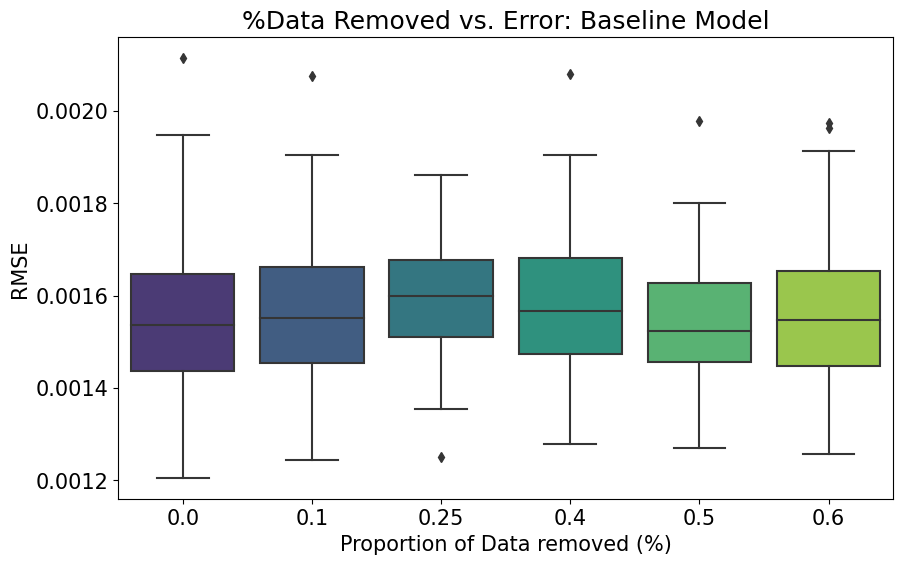

In [16]:
#### For baseline model
bs_rmse_df=pd.DataFrame(rmse_dist)
bs_rmse_df.columns = to_remove
bs_rmse_df.to_pickle('simulation_data/bs_rmse_df')

error_long=bs_rmse_df.melt(var_name='removed', value_name='rmse')
fig,axs=plt.subplots(figsize=(10,6))
sns.boxplot(data=error_long, x='removed',y='rmse', palette=sns.color_palette("viridis"))
axs.set_xlabel('Proportion of Data removed (%)')
axs.set_ylabel('RMSE')
axs.set_title('%Data Removed vs. Error: Baseline Model')
plt.show()

### CONSTRUCTION ZONE BEYOND THIS CELL###
![construction sign](https://media.istockphoto.com/id/1423867660/vector/traffic-road-barrier-road-closed-warning-barrier-flat-vector-illustrations-for-website-under.jpg?s=1024x1024&w=is&k=20&c=xXqtDUeaaaFlqN4cFyvv6rBLyzpuZF89cEKbus2Rw-M=)

### Perform time series train-test split and blocked cross validation (jk i don't think this works)
- Split time series data into training and testing
- Perform k-fold cross validation on varying blocks

**References**
- TS CV [blog post](https://goldinlocks.github.io/Time-Series-Cross-Validation/)
- Netpune AI [tutorial](https://neptune.ai/blog/select-model-for-time-series-prediction-task)
- Medium [blog post ](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

In [ ]:
# helper function to 
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
#     # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) #+ ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.1], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [45]:
# code from reference listed above
## class to define blocked split for training and testing data for time series CV
class BlockingTimeSeriesSplit():
    # initialize object
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    # class function to return # splits
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    # function to create blocked splits by works by adding margins at two positions. The first is between the 
    # training and validation folds in order to prevent the model from observing lag values which are used twice, 
    # once as an estimator (regressor) and another as a response. The second is between the folds used at 
    # each iteration in order to prevent the model from memorizing patterns from one iteration to the next.
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        # get size of each split
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        # split evenly between training and testing
        margin = 0
        # get indices of data for each split 
        for i in range(self.n_splits):
            # set beginning and end of split
            start = i * k_fold_size
            stop = start + k_fold_size
            # get middle of split to start testing
            mid = int(0.5 * (stop - start)) + start
            # pause function to return splits for training and testing
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# visualize split for normal time series split and blocking
cvs = [TimeSeriesSplit, BlockingTimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_cv_indices(this_cv, X, y, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
            ['Testing set', 'Training set'], loc=(1.02, .8))
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
        
plt.show()

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
# create time series split object
tscv = TimeSeriesSplit(n_splits = 4)
# set error metrics
rmse = []
# run grab training indices from truth data
NPP_truth=tsd_df.NPP.values
# for train_index, test_index in tscv.split(cross_validation):
#     cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
#     arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
#     predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
#     true_values = cv_test.values
#     rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
# print("RMSE: {}".format(np.mean(rmse)))

In [43]:
counter=0
for train_index, test_index in tscv.split(NPP_truth):
    print(counter)
    print(f'train: {train_index}')
    print(f'test: {test_index}')
    counter+=1

0
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
test: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
1
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
test: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
2
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
test: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
3
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 